In [1]:
import torch
from tqdm import tqdm
import utils
from model import TimeSeriesTransformer
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from psd import power_spectrum_error, compute_power_spectrum, get_average_spectrum
from torch import nn, Tensor
import math
from torch.utils.data import Dataset
from typing import Tuple
import csv
from torch.utils.data import DataLoader

In [2]:
os.chdir("..")  # change dir to main branch

In [3]:
# Just some helper functions

def generate_square_subsequent_mask(dim1: int, dim2: int):
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


def get_indices_entire_sequence(data: Tensor, window_size: int, step_size: int) -> list:

    start_index = 0
    stop_index = window_size

    list_indices = []

    # go through all available timeframes
    while stop_index < len(data):
        list_indices.append((start_index, stop_index))

        start_index += step_size
        stop_index += step_size

    return list_indices


def read_data(data_dir:str) -> Tensor:
    array = np.load(data_dir)
    print(f"Loaded data shape: {array.shape}")
    
    return torch.from_numpy(array)



In [4]:
class TransformerDataset(Dataset):
    def __init__(self,
                 data: torch.tensor,
                 indices: list,
                 enc_seq_len: int,
                 dec_seq_len: int,
                 target_seq_len: int
                 ) -> None:
        super().__init__()
        self.indices = indices
        self.data = data
        self.enc_seq_len = enc_seq_len
        self.dec_seq_len = dec_seq_len
        self.target_seq_len = target_seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        # Get the first element of the i'th tuple in the list self.indicesasdfas
        start_idx = self.indices[index][0]

        # Get the second (and last) element of the i'th tuple in the list self.indices
        end_idx = self.indices[index][1]

        sequence = self.data[start_idx:end_idx]

        src, trg, trg_y = self.get_src_trg(
            sequence=sequence,
            enc_seq_len=self.enc_seq_len,
            target_seq_len=self.target_seq_len
        )

        return src, trg, trg_y

    def get_src_trg(
            self,
            sequence: torch.Tensor,
            enc_seq_len: int,
            target_seq_len: int
    ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        assert len(
            sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"

        # encoder input
        src = sequence[:enc_seq_len]
        trg = sequence[enc_seq_len - 1:len(sequence) - 1]
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]
        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y

Now we define the TimeSeriesTransformer

In [5]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 input_size: int,
                 dec_seq_len: int,
                 d_model: int = 512,
                 n_encoder_layers: int = 4,
                 n_decoder_layers: int = 4,
                 dropout: float = 0.2,
                 max_seq_len: int = 512,
                 dim_feedforward_encoder: int = 2048,
                 n_heads: int = 8,
                 dim_feedforward_decoder: int = 2048,
                 num_predicted_features: int = 3
                 ):

        super().__init__()
        # positional encoder

        self.dropout = nn.Dropout(p=dropout)

        # create array for positional encoding
        position_counter = torch.arange(max_seq_len).unsqueeze(1)
        # taken from the positional encoding torch tutorial
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # create positional encoding shift to add to the sequential data
        pos_encoding = torch.zeros(1, max_seq_len, d_model)
        pos_encoding[0, :, 0::2] = torch.sin(position_counter * div_term)
        pos_encoding[0, :, 1::2] = torch.cos(position_counter * div_term)

        # this makes torch register the positional encoding as non-trainable parameter
        self.register_buffer('pe', pos_encoding)

        # encoder


        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=d_model
        )

        # Create positional encoder from other module

        # now build encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead = n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout,
            batch_first=True
        )

        # stack encoder layers to obtain Encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers,
            norm=None
        )

        self.dec_seq_len = dec_seq_len

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=d_model,
        )

        # create one decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout,
            batch_first=True
        )

        # stack the decoder layers
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers,
            norm=None
        )

        self.linear_mapping = nn.Linear(
            in_features=d_model,
            out_features=num_predicted_features
        )

    def pos_encoding(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val]

        returns: Tensor, shape [batch_size,enc_seq_len, dim_val]
        """
        #print(f"forward tensor shape: {x.shape}, pos enc shape: {self.pe[:, :x.size(1)].shape}")
        x = x + self.pe[:,:x.size(1)]

        return self.dropout(x)


    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, tgt_mask: Tensor=None) -> Tensor:

        src = self.encoder_input_layer(src)

        # Pass through the positional encoding layer
        # src = src.unsqueeze(0)
        pos_encoded_src = self.pos_encoding(src)

        encoder_output = self.encoder(
            src=pos_encoded_src
        )

        tgt = self.decoder_input_layer(tgt)

        decoder_output = self.decoder(
            tgt=tgt,
            memory=encoder_output,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
        )

        decoder_output = self.linear_mapping(decoder_output)

        return decoder_output

Now the training procedure of the neural network

In [6]:
def train_TimeSeriesTransformer(data_path, args):
    # Training parameters
    epochs = args["epochs"]
    batch_size = args["batch_size"]

    # Initialize data
    data = utils.read_data(data_path)

    ## Params from args
    dec_seq_len = args["dec_seq_len"]
    enc_seq_len = args["enc_seq_len"]
    output_seq_len = args["output_seq_len"]
    window_size = args["window_size"]
    step_size = args["step_size"]


    training_indices = utils.get_indices_entire_sequence(
        data=data,
        window_size=window_size,
        step_size=step_size)

    training_data = TransformerDataset(data=data,
                                     indices=training_indices,
                                     enc_seq_len=enc_seq_len,
                                     dec_seq_len=dec_seq_len,
                                     target_seq_len=output_seq_len)

    training_data = DataLoader(training_data, batch_size,shuffle=True)

    model = TimeSeriesTransformer(
        input_size=data.shape[1],  # Assuming 'data' is already loaded
        dec_seq_len=args["dec_seq_len"],
        d_model=args["dim_val"],
        n_encoder_layers=args["n_encoder_layers"],
        n_decoder_layers=args["n_decoder_layers"],
        dropout=0.2,
        max_seq_len=args["max_seq_len"],
        dim_feedforward_encoder=args["in_features_encoder_linear_layer"],
        n_heads=args["n_heads"],
        dim_feedforward_decoder=args["in_features_decoder_linear_layer"],
        num_predicted_features= data.shape[1] # Assuming prediction targets match input features
    )


    optimizer = torch.optim.Adam(params=model.parameters())
    criterion = torch.nn.HuberLoss()

    # Make src mask for decoder with size:
    # [batch_size*n_heads, output_sequence_length, enc_seq_len]
    src_mask = utils.generate_square_subsequent_mask(
        dim1=output_seq_len,
        dim2=enc_seq_len
        )

    # Make tgt mask for decoder with size:
    # [batch_size*n_heads, output_sequence_length, output_sequence_length]
    tgt_mask = utils.generate_square_subsequent_mask(
        dim1=output_seq_len,
        dim2=output_seq_len
        )

    losses = []

    # Iterate over all epochs
    for epoch in tqdm(range(epochs)):

        # Iterate over all (x,y) pairs in training dataloader
        for i, (src, tgt, tgt_y) in enumerate(training_data):
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(src.shape, tgt.shape)

            # Make forecasts
            #print(f"src: {src.shape}, tgt: {tgt.shape}")
            prediction = model(src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask)

            # Compute and backprop loss
            loss = criterion(tgt_y, prediction)
            losses.append(loss.detach())

            loss.backward()

            # Take optimizer step
            optimizer.step()

        # Iterate over all (x,y) pairs in validation dataloader



    model_name = args["model_name"]
    torch.save(model.state_dict(), f"models/{model_name}.pth")

    plt.plot(range(len(losses)),losses)
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.savefig(f"plots/training_{model_name}.png")

    # Save hyperparameters as CSV
    with open(f"models/{model_name}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Name", "Age"])  # Column headers
        for key, value in args.items():
            writer.writerow([key, value])

Now we want to test our model by generating new data time series data from scratch

In [7]:
def generate_TimeSeriesTransformer(data_path_train,data_path,args):

    # data for comparison/ validation
    data_validation = utils.read_data(data_path)
    
    # numver of warmup steps
    warmup_steps = 100

    model_name = args["model_name"]
    enc_seq_len = args["enc_seq_len"]
    output_seq_len = args["output_seq_len"]

    data_train = utils.read_data(data_path_train)

    # Load the trained model
    model_path = f"models/{model_name}.pth"  # Change path if needed
    model = TimeSeriesTransformer(
        input_size=data_validation.shape[1],  # Assuming 'data' is already loaded
        dec_seq_len=args["dec_seq_len"],
        d_model=args["dim_val"],
        n_encoder_layers=args["n_encoder_layers"],
        n_decoder_layers=args["n_decoder_layers"],
        dropout=0.2,  # Default value
        max_seq_len=args["max_seq_len"],
        dim_feedforward_encoder=args["in_features_encoder_linear_layer"],
        n_heads=args["n_heads"],
        dim_feedforward_decoder=args["in_features_decoder_linear_layer"],
        num_predicted_features= data_validation.shape[1]  # Assuming prediction targets match input features
    )
    
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

    # load trained model
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()  # Set to evaluation mode
        print("Model loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file not found at {model_path}")

    # take some random initial condition from the training set
    start = random.randrange(len(data_train)-enc_seq_len-output_seq_len-1)
    initial_condition = data_train[start:start+enc_seq_len + output_seq_len]
    initial_condition = initial_condition.unsqueeze(0)

    print("Creating new time series")


    # first warm up the model to get away from initial condition  
    warmup_time_series = initial_condition

    with torch.no_grad():
        for _ in range(warmup_steps):
            # devide data into src and tgt (encoder and decoder input)
            src = warmup_time_series[:, :enc_seq_len]
            tgt = warmup_time_series[:, enc_seq_len - 1:warmup_time_series.shape[1] - 1]

            # calculate output
            output = model(src=src, tgt=tgt)


            warmup_time_series = torch.cat((warmup_time_series, output[:,-1].unsqueeze(0)), dim=1)
            warmup_time_series = warmup_time_series[:, 1:]

    
    generated_time_series = warmup_time_series
    current_generated_time_series = warmup_time_series

    # now generate the displayed time series

    with torch.no_grad():
        for _ in tqdm(range(int(data_validation.shape[0]))):
            src = current_generated_time_series[:, :enc_seq_len]
            tgt = current_generated_time_series[:, enc_seq_len - 1:current_generated_time_series.shape[1] - 1]

            output = model(src=src, tgt=tgt)
            generated_time_series = torch.cat((generated_time_series, output[:,-1].unsqueeze(0)), dim=1)
            current_generated_time_series = torch.cat((current_generated_time_series, output[:,-1].unsqueeze(0)), dim=1)
            current_generated_time_series = current_generated_time_series[:, 1:]


    # cute time series to be the right length
    generated_time_series = generated_time_series[:,:data_validation.shape[0]]



    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    generated_trajectory = torch.transpose(generated_time_series.squeeze(0),dim0=0,dim1=1)
    np.save(f"data/generated_trajectory_{model_name}.npy", generated_time_series)

    x,y,z = generated_trajectory[:3]
    x_or,y_or,z_or = torch.transpose(data_validation[:,:3],dim0=0,dim1=1)

    # Plot the trajectory
    ax.plot(x, y, z, label='3D Trajectory', color='b',alpha=0.7)
    ax.plot(x_or, y_or, z_or, label='Original Trajectory', color='r',alpha=0.2)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Trajectory Plot")

    # Show the legend
    ax.legend()

    # Display the plot
    plt.savefig(f"plots/3D_Trajectory_model{model_name}.png")
    plt.show()
    #plt.close()

In [22]:
def analyze_generated_trajectories(model_name,data_validation_path):

    generated_trajectory = utils.read_data(f"data/generated_trajectory_{model_name}.npy")
    test_trajectory = utils.read_data(data_validation_path)

    #print(generated_trajectory.shape,test_trajectory.shape)

    freqs = np.fft.rfftfreq(generated_trajectory.shape[1])
    # sort frequencies by their magnitude
    idx = np.argsort(freqs)
    ps = get_average_spectrum(generated_trajectory)
    ps_or = get_average_spectrum(test_trajectory.unsqueeze(0))

    num_dims = generated_trajectory.shape[2]  # Number of dimensions

    # Create subplots, one per dimension
    fig, axes = plt.subplots(num_dims, 1, figsize=(8, 4 * num_dims), sharex=True)

    for dim in range(min(num_dims,3)):  # Loop over dimensions , max 3
        ax = axes[dim]
        ax.plot(freqs[idx], ps_or[0,:,dim], label=f'Original (Dim {dim +1})', linestyle="-", color="blue")
        ax.plot(freqs[idx], ps[0,:,dim], label=f'Generated (Dim {dim + 1})', linestyle="--", color="red")
        ax.set_ylabel("Power")
        ax.set_title(f"Power Spectrum (Dimension {dim + 1})")
        ax.legend()
        ax.grid(True)

    # Common labels
    axes[-1].set_xlabel("Frequency")
    plt.suptitle("Power Spectrum Comparison per Dimension")
    plt.tight_layout()

    plt.title(f"Power Spectrum")
    plt.xlabel("Frequency")
    plt.savefig(f"plots/{model_name}_power_spectrum.png")
    plt.close()

    ps_error = power_spectrum_error(generated_trajectory, test_trajectory.unsqueeze(0))
    print(f"The power spectrum error amounts to: {ps_error}")


In [9]:

# Define the args dictionary with values
args63 = {
    "model_name": "Lorenz63",
    "epochs": 3,
    "batch_size": 32,
    "dim_val": 256,
    "n_heads": 8,
    "n_decoder_layers": 2,
    "n_encoder_layers": 2,
    "dec_seq_len": 64,  # length of input given to decoder
    "enc_seq_len": 128,  # length of input given to encoder
    "output_seq_len": 32,  # target sequence length
    "window_size": 128 + 32,  # enc_seq_len + output_seq_len
    "step_size": 25,  # Step size for moving window
    "in_features_encoder_linear_layer": 512,
    "in_features_decoder_linear_layer": 512,
    "max_seq_len": 128,  # Same as enc_seq_len
}


args96 = {
    "model_name": "Lorenz96",
    "epochs": 3,
    "batch_size": 32,
    "dim_val": 512,
    "n_heads": 8,
    "n_decoder_layers": 2,
    "n_encoder_layers": 2,
    "dec_seq_len": 64,  # length of input given to decoder
    "enc_seq_len": 128,  # length of input given to encoder
    "output_seq_len": 32,  # target sequence length
    "window_size": 128 + 32,  # enc_seq_len + output_seq_len
    "step_size": 25,  # Step size for moving window
    "in_features_encoder_linear_layer": 1024,
    "in_features_decoder_linear_layer": 1024,
    "max_seq_len": 128,  # Same as enc_seq_len
}

Now for executing the code:

### Lorenz63

Loaded data shape: (100000, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [21:22<00:00, 427.65s/it]


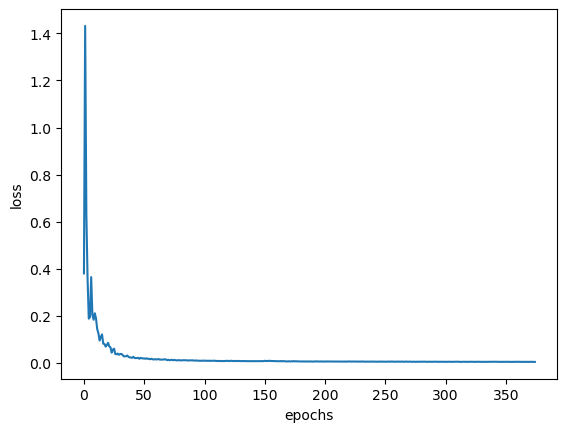

In [10]:
data_path63 = "data/lorenz63_on0.05_train.npy"
train_TimeSeriesTransformer(data_path=data_path63,args=args63)

Loaded data shape: (100000, 3)
Loaded data shape: (100000, 3)
Model loaded successfully!
Creating new time series


/tmp/ipykernel_18380/3253042598.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
100%|████████████████

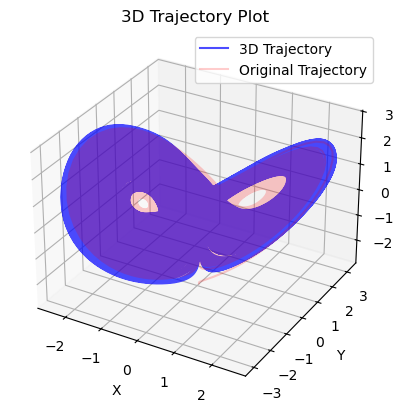

In [11]:
data_path_train = "data/lorenz63_on0.05_train.npy"
data_path = "data/lorenz63_test.npy"
generate_TimeSeriesTransformer(data_path=data_path,data_path_train=data_path_train,args=args63)

In [23]:
data_path_train = "data/lorenz63_on0.05_train.npy"
data_path = "data/lorenz63_test.npy"
analyze_generated_trajectories(model_name=args63["model_name"], data_validation_path=data_path)

Loaded data shape: (1, 100000, 3)
Loaded data shape: (100000, 3)
The power spectrum error amounts to: 0.47443028519247726


### Lorenz96

Loaded data shape: (100000, 20)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [16:01<00:00, 320.42s/it]


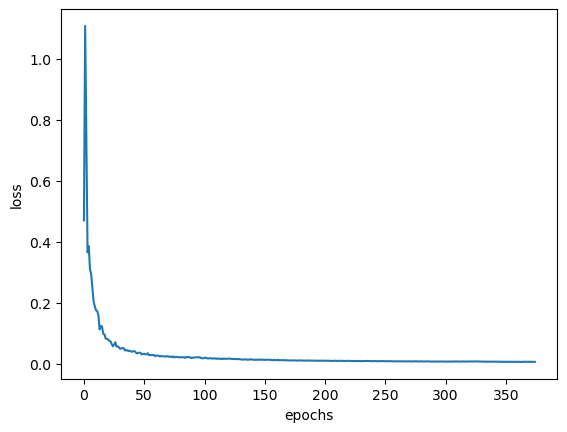

In [13]:
data_path96 = "data/lorenz96_on0.05_train.npy"
train_TimeSeriesTransformer(data_path=data_path96, args=args96)

Loaded data shape: (100000, 20)
Loaded data shape: (100000, 20)


/tmp/ipykernel_18380/3253042598.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully!
Creating new time series


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [7:05:15<00:00,  3.92it/s]


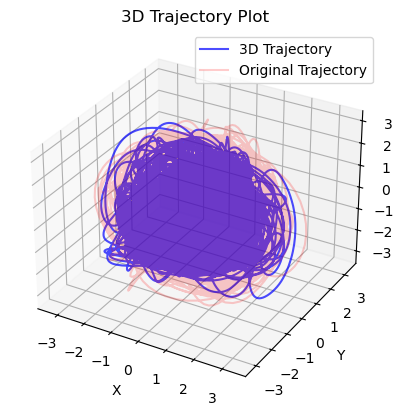

In [20]:
data_path_train = "data/lorenz96_on0.05_train.npy"
data_path = "data/lorenz96_test.npy"
generate_TimeSeriesTransformer(data_path=data_path, data_path_train=data_path_train, args=args96)

In [24]:
data_path_train = "data/lorenz96_on0.05_train.npy"
data_path = "data/lorenz96_test.npy"
analyze_generated_trajectories(model_name=args96["model_name"], data_validation_path=data_path)

Loaded data shape: (1, 100000, 20)
Loaded data shape: (100000, 20)
The power spectrum error amounts to: 0.4560659416456872
